<a href="https://colab.research.google.com/github/Vishal1711/behavioural_cloning/blob/master/behavioural_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!git clone https://github.com/Vishal1711/behavioural_cloning

fatal: destination path 'behavioural_cloning' already exists and is not an empty directory.


In [38]:
!ls

behavioural_cloning  sample_data


In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [40]:
datadir = 'behavioural_cloning'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_439.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\left_2021_12_31_13_47_58_439.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\right_2021_12_31_13_47_58_439.jpg,0.0,0.0,0.0,0.000079
1,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_540.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\left_2021_12_31_13_47_58_540.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\right_2021_12_31_13_47_58_540.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_642.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\left_2021_12_31_13_47_58_642.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\right_2021_12_31_13_47_58_642.jpg,0.0,0.0,0.0,0.000084
3,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_742.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\left_2021_12_31_13_47_58_742.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\right_2021_12_31_13_47_58_742.jpg,0.0,0.0,0.0,0.000082
4,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_845.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\left_2021_12_31_13_47_58_845.jpg,C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\right_2021_12_31_13_47_58_845.jpg,0.0,0.0,0.0,0.000078


In [41]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2021_12_31_13_47_58_439.jpg,left_2021_12_31_13_47_58_439.jpg,right_2021_12_31_13_47_58_439.jpg,0.0,0.0,0.0,0.000079
1,center_2021_12_31_13_47_58_540.jpg,left_2021_12_31_13_47_58_540.jpg,right_2021_12_31_13_47_58_540.jpg,0.0,0.0,0.0,0.000078
2,center_2021_12_31_13_47_58_642.jpg,left_2021_12_31_13_47_58_642.jpg,right_2021_12_31_13_47_58_642.jpg,0.0,0.0,0.0,0.000084
3,center_2021_12_31_13_47_58_742.jpg,left_2021_12_31_13_47_58_742.jpg,right_2021_12_31_13_47_58_742.jpg,0.0,0.0,0.0,0.000082
4,center_2021_12_31_13_47_58_845.jpg,left_2021_12_31_13_47_58_845.jpg,right_2021_12_31_13_47_58_845.jpg,0.0,0.0,0.0,0.000078


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


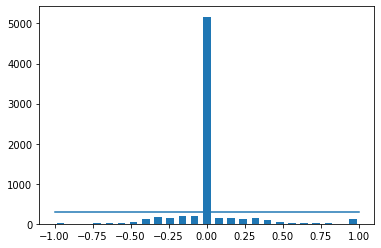

In [42]:
num_bins =25
samples_per_bin = 300
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 7044
removed: 4869
remaining: 2175


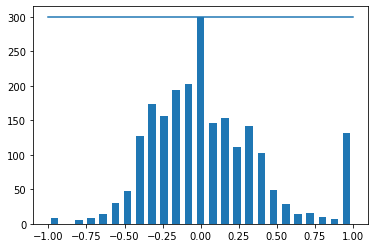

In [43]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [44]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  


center      center_2021_12_31_13_47_59_759.jpg
left        left_2021_12_31_13_47_59_759.jpg  
right       right_2021_12_31_13_47_59_759.jpg 
steering   -0.406038                          
throttle    0.81258                           
reverse     0                                 
speed       3.49741                           
Name: 13, dtype: object


In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 5220
Valid Samples: 1305


Text(0.5, 1.0, 'Validation set')

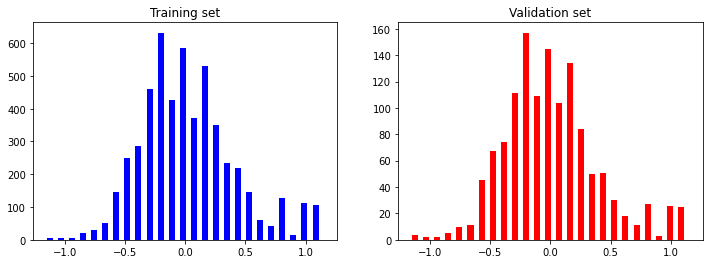

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [47]:
def img_preprocessing(img):
  img = mpimg.imread(img)
  img = img[60:137,:,: ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'preprocessed_image')

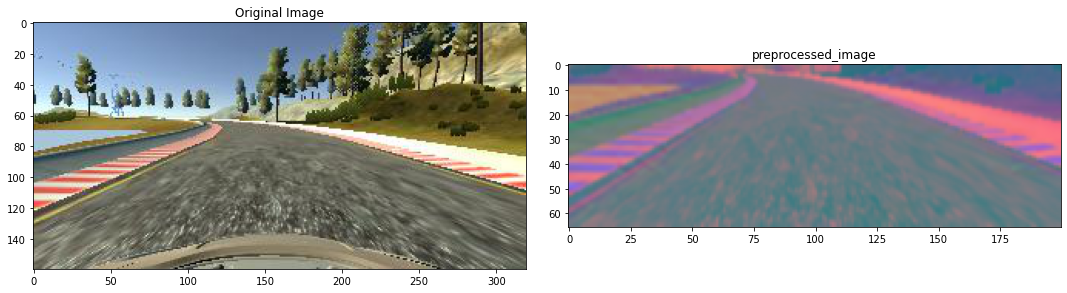

In [48]:
image = image_paths[348]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessing(image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

(5220, 66, 200, 3)


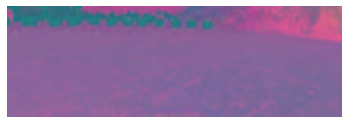

In [49]:
X_train = np.array(list(map(img_preprocessing, X_train)))
X_valid = np.array(list(map(img_preprocessing, X_valid)))
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [50]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [51]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout_2 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [52]:
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid), batch_size=200, verbose=1, shuffle=1)

Epoch 1/20
27/27 [==============================] - 4s 96ms/step - loss: 0.1440 - val_loss: 0.2091
Epoch 2/20
27/27 [==============================] - 2s 77ms/step - loss: 0.1229 - val_loss: 0.1041
Epoch 3/20
27/27 [==============================] - 2s 77ms/step - loss: 0.0823 - val_loss: 0.0714
Epoch 4/20
27/27 [==============================] - 2s 77ms/step - loss: 0.0692 - val_loss: 0.0542
Epoch 5/20
27/27 [==============================] - 2s 77ms/step - loss: 0.0567 - val_loss: 0.0608
Epoch 6/20
27/27 [==============================] - 2s 76ms/step - loss: 0.0530 - val_loss: 0.0517
Epoch 7/20
27/27 [==============================] - 2s 76ms/step - loss: 0.0507 - val_loss: 0.0470
Epoch 8/20
27/27 [==============================] - 2s 75ms/step - loss: 0.0468 - val_loss: 0.0456
Epoch 9/20
27/27 [==============================] - 2s 76ms/step - loss: 0.0448 - val_loss: 0.0473
Epoch 10/20
27/27 [==============================] - 2s 76ms/step - loss: 0.0431 - val_loss: 0.0445
Epoch 11/

Text(0.5, 0, 'Epoch')

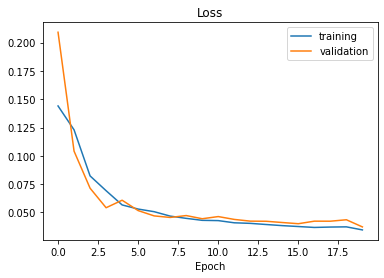

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [54]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>